Zach Tretter

March 10 2021

Problem Statement:

Joe has been working as a technician on the floor for the past 5 years building widgets. He has been getting frustrated seeing so many widgets that he builds not pass specifications where the specifications requires the widget to be greater than a measured value of 85 cm. He has come up with a great idea to improve the process. He has measured 250 units before the process improvement (Pre) and then he measured 250 units after the process improvement (Post).

Question: Did Joe’s improvement make any difference?  

---
---
---

**Approach to Problem**
 * Inspect dataframe for missing and erroneous values
  * Small size of dataset (500 rows by 4 columns) means we can evaluate each feature directly
  * Ensure column data types are valid
 * Analyze target data (dependent variable)
  * Look for outliers in target variable through data visualization
  * Statistically evaluate target data against parameter of interest (process improvement)
 * Explore target data against other independent variables
  * In this example it’s only datetime data
  * Look for correlations and potential relationships


**Assumptions**
* All else equal with respect to production process
 * e.g. requirements, unit cost, production rate, staffing, etc
 * Units were produced sequentially without major production breaks other than this process improvement
* All that matters is if the widget > 85 cm
 * i.e. 85.001 cm and 125 cm are equally good
 * Similarly 65 cm and 84.999 cm are equally bad
* Some measured values are bad (erroneous) data

---

**Unknowns**
* Were 250 widgets made before the process improvement or 10 million?
* Are the 250 a representative and or sufficiently random sample of each production process?

**After Joe's improvement the number of defective units decreased by 33%!**
 * Numerically true but a misleading conclusion
 
---

**Findings**
* No statistical difference in *mean* widget value of pre and post process improvement lots
* Borderline statistical difference in *proportion* of lot that meets 85 cm length criteria
 * p value of 0.12 for difference in proportion
 * Pre Improvement : 93%, Post Improvement: 95%
 * Unbalanced classes in data (94% of all widgets are good to begin with)
* Statistical difference in *variance* of widget length (less variance in post improvement lots)
 * Unclear if this matters
* No statistical difference in *Mean Time Between Failure* Pre and Post improvement
 * MBTF as measured by streak of successful widgets before failure
 * Expect same conclusion as difference in proportions (fewer bad units --> longer streaks of good units)
* No meaningful *correlations* between datetime values and whether a widget is good
 * e.g. certain days of week or times of day no more or less likely to produce good widgets
 
---
 
**Conclusion**
* In late November and early December 2018 there was a spike in the frequency of defective widgets
* Joe and/or plant leadership noticed the increase in defective widgets and requested mitigations
* After the New Year this spike abated for reason unknown and the frequency of bad widgets reverted to the mean
* Joe implemented a new process to reduce defective units in late January 2019
* There is no conclusive evidence Joe's process improvement had any impact without knowing what caused the spike in defective units in late 2018 as the failure rate reverted to the mean before his production change took place

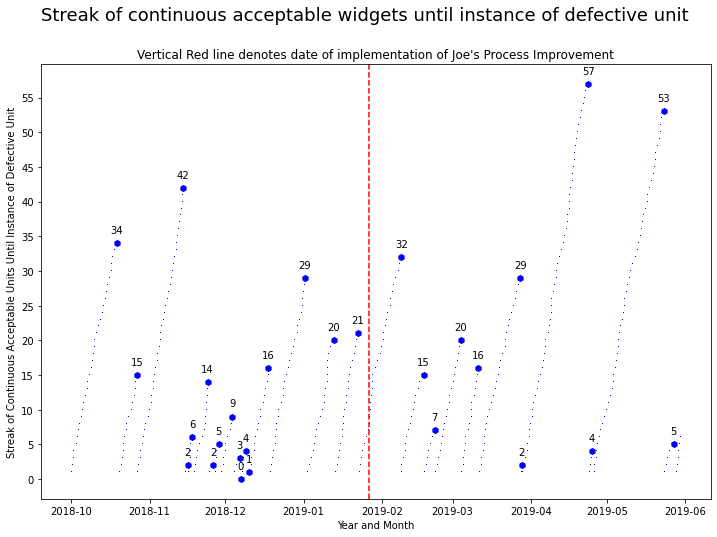

Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from datetime import datetime as dt

Import dataframe

In [2]:
df = pd.read_excel("interviewQuestionData.xlsx")

Rename Columns for ease of use

In [3]:
df = df.rename(columns={
    'Unit':'unit',
    'Date':'date',
    'Process':'process',
    'Measured Value (cm)':'value'
})

## Data Inspection and Clean Up

### Look at whole dataframe

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   unit     500 non-null    int64         
 1   date     500 non-null    datetime64[ns]
 2   process  500 non-null    object        
 3   value    500 non-null    object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 15.8+ KB


### Inspect unit ID column

For 'unit' we expect the first 500 ints sequentially

In [5]:
df['unit'].to_list() == list(range(1,501))

True

No obvious issues encountered

### Inspect data column

For 'date' we expect every value to be within the past few years

In [6]:
df['date'].describe()

count                            500
unique                           500
top       2019-04-07 13:46:55.546000
freq                               1
first            2018-10-01 01:22:13
last      2019-05-30 00:45:08.069000
Name: date, dtype: object

No obvious issues with dates

### 1.3 Inspect the process column
Should only be two values "Pre" or "Post" with equal counts of each

In [7]:
df['process'].value_counts()

Pre     248
Post    248
Pos       2
Pre-      1
Pr        1
Name: process, dtype: int64

Fairly straightforward that "Pos" should be "Post" and both "Pr" and "Pre-" should be "Pre"

It's only a handful of values so we can rename manually

In [8]:
df.loc[ (df['process']=='Pos'), 'process'] = "Post"

df.loc[ (df['process']=='Pr'), 'process'] = "Pre"

df.loc[ (df['process']=='Pre-'), 'process'] = "Pre"

Confirm the last "pre" unit is before the first "post" unit

In [9]:
# Date of last unit pre improvement
date_last_pre = df.loc[(df['process']=='Pre')]['date'].max() 

# Date of first unit post improvement
date_first_post = df.loc[(df['process']=='Post')]['date'].min()

date_last_pre < date_first_post

True

Confirm corrections are present

In [10]:
df['process'].value_counts()

Pre     250
Post    250
Name: process, dtype: int64

### Inspect the measured value column

We expect all measured values to be floats

In [11]:
value_types = [type(i) for i in df['value']]

print({x:value_types.count(x) for x in value_types})

{<class 'float'>: 495, <class 'str'>: 5}


Examine these non-float values in more detail --> there's only 5 of them

In [12]:
flawed_values = [i for i in df['value'] if type(i)!=float]

for i in flawed_values:
    for letter in i:
        if letter.isalpha():
            print(letter+ " found in " + i)

O found in 103.483O49398752
l found in 91.84l512161515
l found in 10l.662343214907
O found in 98.3O42545338963
l found in 14.040l9942202


Reasonable to conclude the string literals in these values, "l" and "O", are actually, "1" and "0" respectively

It's only five values so we can update the values with a simple replace function

In [13]:
def fix_letters(value):
    if type(value) == str:
        value = value.replace("O","0")
        value = value.replace("l","1")
        value = float(value)
    return value

Apply the function

In [14]:
df['value'] = df['value'].apply(fix_letters)

Confirm all values are floats

In [15]:
value_types = [type(i) for i in df['value']]

print({x:value_types.count(x) for x in value_types})

{<class 'float'>: 500}


### Engineer Feature - Identify if a widget passes inspection

In [16]:
df['good_widget'] = (df['value']>85).astype(int)

### Engineer Feature - Identify how much a widget fares against the 85cm length standard

In [17]:
df['delta_length'] = df['value']-85

### Review our cleaned dataframe

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   unit          500 non-null    int64         
 1   date          500 non-null    datetime64[ns]
 2   process       500 non-null    object        
 3   value         500 non-null    float64       
 4   good_widget   500 non-null    int32         
 5   delta_length  500 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1), object(1)
memory usage: 21.6+ KB


## Data Analysis

### Look for outliers in our target variable

No obvious high bound errors
What to make of values that are order of magnitude less than 99% of data points?


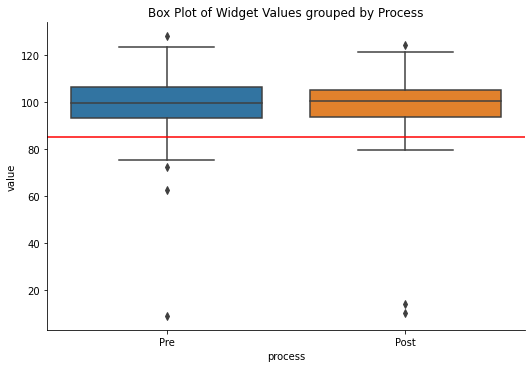

In [19]:
g = sns.catplot(
    data=df,
    x='process',
    y = 'value',
    kind = 'box',
)
plt.axhline(85, color = 'red');
plt.title("Box Plot of Widget Values grouped by Process")
g.fig.set_figwidth(8)
g.fig.set_figheight(5)

print("No obvious high bound errors")
print("What to make of values that are order of magnitude less than 99% of data points?")

### Address anomalies
Remove the 3 values that are an order of magnitude outside the range of 99% of the data set

Removing <1% of our data will not diminish our data set

In [20]:
outliers = df.nsmallest(3,'value')

outliers

,unit,date,process,value,good_widget,delta_length
134,135,2018-12-02 11:58:54.726,Pre,9.046567,0,-75.953433
438,439,2019-04-27 23:36:37.843,Post,10.146494,0,-74.853506
475,476,2019-05-18 09:58:39.946,Post,14.040199,0,-70.959801


In [21]:
df = df.drop(outliers.index)

### Visualize our data again

Post process appear to have less variance than pre process improvement widgets


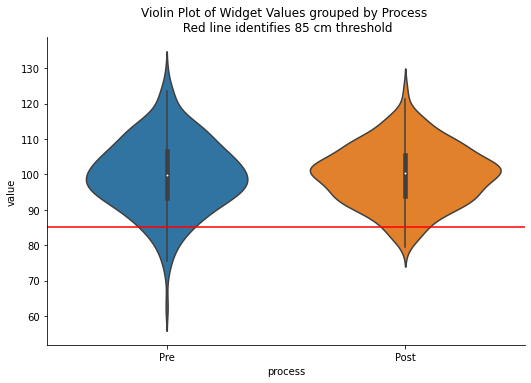

In [22]:
g = sns.catplot(
    data=df,
    x='process',
    y = 'value',
    kind = 'violin',
)
plt.axhline(85, color = 'red');
plt.title("Violin Plot of Widget Values grouped by Process \n Red line identifies 85 cm threshold")
g.fig.set_figwidth(8)
g.fig.set_figheight(5)

print("Post process appear to have less variance than pre process improvement widgets")

In [23]:
pre_values = df.loc[ (df['process']=='Pre'),'value']
post_values = df.loc[ (df['process']=='Post'),'value']

### Is there a difference in widget length variance between pre and post process improvement?

In [24]:
var_stat, var_p = stats.levene(pre_values,post_values)

print('var_stat: %0.3f, var_p: %0.3f' % (var_stat, var_p))
print("\n")
print("A p-value of %0.3f at an alpha of 0.05 tells us that we cannot conclude these two production lots have the same variance" % (var_p))


var_stat: 6.218, var_p: 0.013


A p-value of 0.013 at an alpha of 0.05 tells us that we cannot conclude these two production lots have the same variance


### Difference in Mean Widget Value?

In [25]:
mean_stat, mean_p = stats.ttest_ind(pre_values,post_values,equal_var=False)

print('mean_stat: %0.3f, mean_p: %0.3f' % (mean_stat, mean_p))
print("\n")
print("A p-value of %0.3f at an alpha of 0.05 means we fail to reject the null hypothesis and cannot conclude there is a difference in mean widget length" % (mean_p))


mean_stat: -0.297, mean_p: 0.767


A p-value of 0.767 at an alpha of 0.05 means we fail to reject the null hypothesis and cannot conclude there is a difference in mean widget length


### Difference in % of Lot Meeting Threshold?

In [26]:
pd.pivot_table(df,
               values = 'good_widget',
               index = 'process',
               aggfunc=np.mean,
               margins = True)

,good_widget
process,
Post,0.955645
Pre,0.931727
All,0.943662


In [27]:
table = pd.pivot_table(df,
                       values = 'value',
                       index = 'process',
                       columns = 'good_widget',
                       aggfunc=np.count_nonzero,
                       margins = True
                      )
table

good_widget,0,1,All
process,,,
Post,11.0,237.0,248.0
Pre,17.0,232.0,249.0
All,28.0,469.0,497.0


In [28]:
good_count_pre = df.loc[ ((df['process']=='Pre') & (df['good_widget']==1))].shape[0]
lot_size_pre = df.loc[ ((df['process']=='Pre'))].shape[0]

good_count_post = df.loc[ ((df['process']=='Post') & (df['good_widget']==1))].shape[0]
lot_size_post = df.loc[ ((df['process']=='Post'))].shape[0]

In [29]:
# Code leveraged from from https://sonalake.com/latest/hypothesis-testing-of-proportion-based-samples/

good_widgets = np.array([good_count_pre,good_count_post])
lot_sizes = np.array([lot_size_pre,lot_size_post])

proportion_z_stat, proportion_p_value = sm.stats.proportions_ztest(
    count = good_widgets,
    nobs = lot_sizes,
    alternative = 'smaller'
)

print('proportion_z_stat: %0.3f, proportion_p_value: %0.3f' % (proportion_z_stat, proportion_p_value))
print("\n")
print('At any typical significance level, a p value of %0.3f is not sufficient to conclude there is a different in what proportion of each lot meets the 85 cm threshold' % (proportion_p_value))

proportion_z_stat: -1.156, proportion_p_value: 0.124


At any typical significance level, a p value of 0.124 is not sufficient to conclude there is a different in what proportion of each lot meets the 85 cm threshold


### Mean Time Between Failure (Sort of)

Calculate the Streak of Successfull Widgets

In [30]:
MBTF = []

streak = 0

for i in df.index:
    if df['good_widget'][i]==1:
        streak +=1
        MBTF.append(streak)
    else:
        MBTF.append(streak)
        streak = 0
        

Add this to our dataframe

In [31]:
df['mbtf']=MBTF
print("\n")
df.loc[(df['good_widget']==0)].groupby('process')['mbtf'].describe()[['count','mean','std']]

,count,mean,std
process,,,
Post,11.0,21.818182,19.135403
Pre,17.0,13.117647,12.574192


Conduct a T Test for Sample Means

In [32]:
mbtf_pre = df.loc[((df['good_widget']==0) & (df['process']=='Pre')),'mbtf']
mbtf_post = df.loc[((df['good_widget']==0) & (df['process']=='Post')),'mbtf']

mbtf_stat, mbtf_p = stats.ttest_ind(mbtf_pre, mbtf_post, equal_var=False)

print('mbtf_stat: %0.3f, mbtf_p: %0.3f' % (mbtf_stat, mbtf_p))

print("A p-value of %0.3f at an alpha of 0.05 means we fail to reject the null hypothesis and cannot conclude there is a difference in mean time between faulty widgets" % (mbtf_p))


mbtf_stat: -1.333, mbtf_p: 0.202
A p-value of 0.202 at an alpha of 0.05 means we fail to reject the null hypothesis and cannot conclude there is a difference in mean time between faulty widgets


## EDA with Time Data

### Look for correlation with numerical date variables

Create columns for numerical date time variables

In [33]:
# Isolate date
df['calendar_date'] = df['date'].apply(
    lambda x: dt.strftime(x, "%m/%d/%Y"))

# Isolate Year
df['year'] = df['date'].apply(
    lambda x: dt.strftime(x, "%Y")).astype(int)

# Isolate Month as Number
df['month_num'] = df['date'].apply(
    lambda x: dt.strftime(x, "%m")).astype(int)

# Isolate Day of Month
df['day_of_month'] = df['date'].apply(
    lambda x: dt.strftime(x, "%d")).astype(int)

# Isolate Day of Week as Number
df['weekday_num'] = df['date'].apply(
    lambda x: dt.strftime(x, "%w")).astype(int)

# Isolate Time of Day as hours with minutes as decimals representing fractional hours
df['time_of_day'] = df['date'].apply(
    lambda x: float(dt.strftime(x,"%H")) + float(dt.strftime(x,"%M"))/60)

numerical_datetime_fields = ['year','month_num','day_of_month','weekday_num','time_of_day']

Examine Correlations with Target Variables

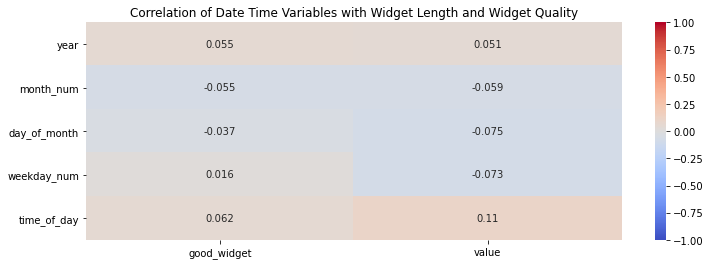

In [34]:
plt.figure(figsize = (12,4))

corr_datetime = df[numerical_datetime_fields+['good_widget','value']].corr()
corr_datetime = corr_datetime.loc[numerical_datetime_fields,['good_widget','value']]

plt.title("Correlation of Date Time Variables with Widget Length and Widget Quality")

sns.heatmap(corr_datetime,
           annot = True,
           cmap = 'coolwarm',
           vmin = -1,
           vmax = 1);

### Visualize occurence of defective units over time

Make the dataframe's index be a datetime value to enable timeseries functionality in pandas

In [35]:
df_date_index = df.set_index('date',inplace = False)

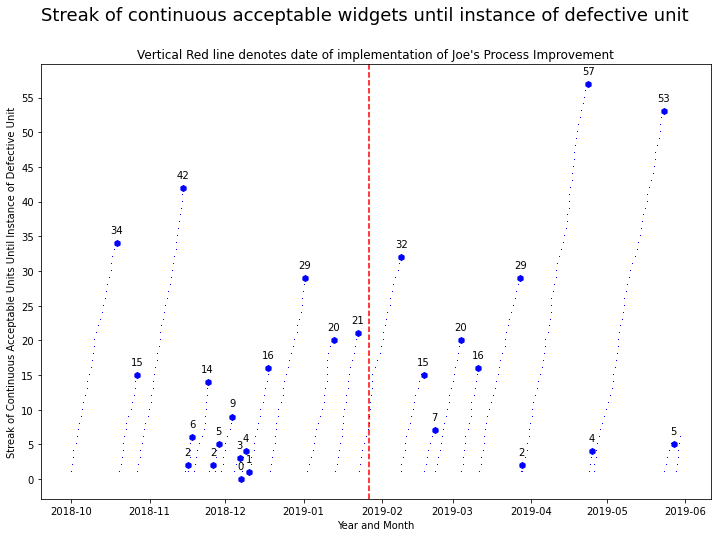

In [36]:
plt.figure(figsize=(12,8))

plt.suptitle("Streak of continuous acceptable widgets until instance of defective unit",fontsize = 18)
plt.title("Vertical Red line denotes date of implementation of Joe's Process Improvement")


plt.axvline(date_last_pre,color='red',ls="--")

plt.yticks(np.arange(0,60,5))
plt.plot(df_date_index['mbtf'],',b',);
plt.plot(df_date_index.loc[df_date_index['good_widget']==0,'mbtf'],"hb")

plt.ylabel('Streak of Continuous Acceptable Units Until Instance of Defective Unit')
plt.xlabel('Year and Month')


# Below code for labels adapted from https://queirozf.com/entries/add-labels-and-text-to-matplotlib-plots-annotation-examples
xs = df_date_index.loc[df_date_index['good_widget']==0,'mbtf'].index
ys = df_date_index.loc[df_date_index['good_widget']==0,'mbtf']

for x,y in zip(xs,ys):

    label = "{:.0f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

### Rolling Average of Widget Measurement over Time

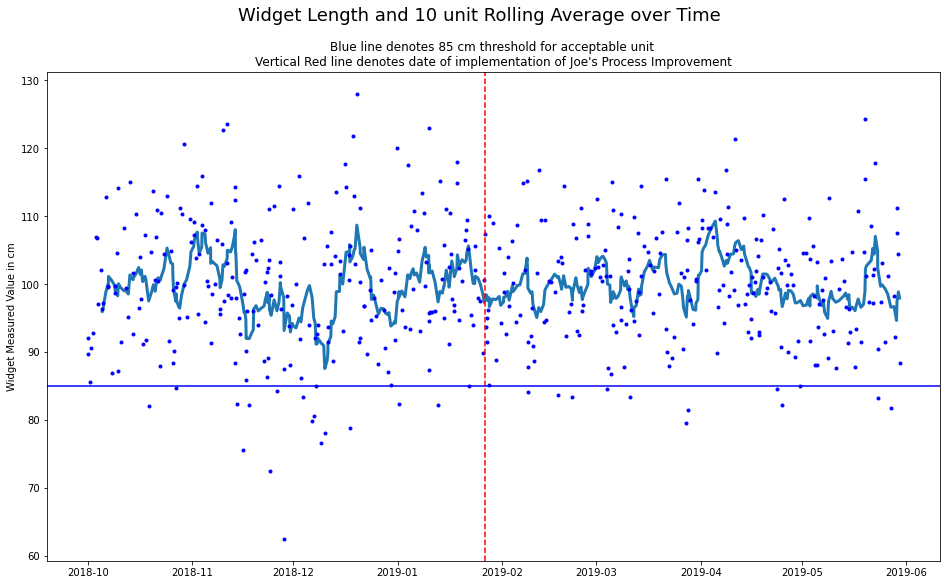

In [37]:
plt.figure(figsize=(16,9))
plt.plot(df_date_index['value'].rolling(10).mean(),lw=3)
plt.plot(df_date_index['value'],".b")

plt.suptitle("Widget Length and 10 unit Rolling Average over Time",fontsize=18)
plt.title("\nBlue line denotes 85 cm threshold for acceptable unit \nVertical Red line denotes date of implementation of Joe's Process Improvement")
plt.ylabel('Widget Measured Value in cm')

plt.axvline(date_last_pre,color='red',ls='--')
plt.axhline(85,color='blue');